In [1]:
import scipy.io as sio
from essentials.create import create_ensemble, create_noisy_signal
from essentials.Util import *
from ML_models.POD_ESN import *


# case = load_from_pickle_file('POD_ESN_case')

mat = sio.loadmat('data/circle_data.mat')
data = np.array([mat['ux'], mat['uy']]).transpose(0, 3, 2, 1)


Nu, Ny, Nx, Nt = data.shape

y_true = np.reshape(data.copy(), newshape=(-1, Nt))
y_true[np.isnan(y_true)] = 0

noise_type, std_obs = 'gauss, add', 0.2
y_raw = create_noisy_signal(y_true, noise_level=std_obs, noise_type=noise_type)
y_raw = np.reshape(y_raw, newshape=(Nu, Ny, Nx, Nt))


N_test = int(.4 * Nt)
X_test = y_raw[..., -N_test:].copy()
X_train = y_raw[..., :-N_test].copy()


sensor_locations = POD_ESN.define_sensors(Nq=5, domain=[-2, 2, 12, 0], grid_shape=data.shape[:-1], 
                                          down_sample=(10, 20))

case = POD_ESN(X=X_train, dt=0.01, N_modes=10, sensor_locations=sensor_locations,
               rho_range = (.2, 1.05), plot_decomposition=True, plot_training=False, perform_test=False)

save_to_pickle_file('POD_ESN_case', case)


MODULO (MODal mULtiscale pOd) is a software developed at the von Karman Institute to perform data driven modal decomposition of numerical and experimental data. 

Modulo assumes you have a uniform grid. If not, please give the weights as parameters of MODULO!
Computing correlation matrix D matrix...

 Computing Temporal correlation matrix K ...

 Done.
Computing Temporal Basis...
diagonalizing K....
Done.
Computing Spatial Basis...
Computing Phi from D...
Done.

 ----------------- HYPERPARAMETER SEARCH ------------------
 4x4 grid and 4 points with Bayesian Optimization
		 rho	 sigma_in	 tikh	 MSE val 
1	 2.000e-01	 1.000e-05	 1.000e-16	 -1.5949
2	 2.000e-01	 2.154e-04	 1.000e-16	 -0.9195
3	 2.000e-01	 4.642e-03	 1.000e-08	 -0.4005
4	 2.000e-01	 1.000e-01	 1.000e-08	 0.4017
5	 4.833e-01	 1.000e-05	 1.000e-08	 -0.5586
6	 4.833e-01	 2.154e-04	 1.000e-10	 -0.9214
7	 4.833e-01	 4.642e-03	 1.000e-08	 0.1412
8	 4.833e-01	 1.000e-01	 1.000e-08	 0.3690
9	 7.667e-01	 1.000e-05	 1.000e-12	 -0.97

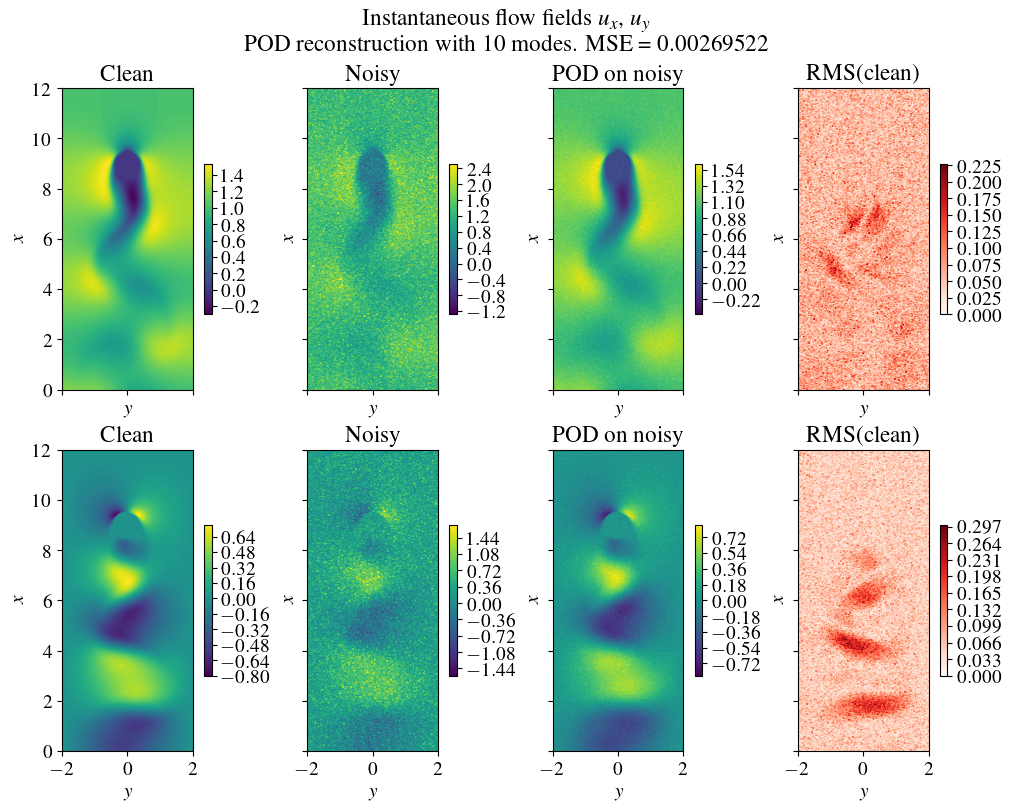

In [2]:


case.plot_reconstruct(original_data=y_raw[..., -N_test], clean_data=data[..., -N_test])


In [3]:

data_obs = X_test.copy().reshape(-1, N_test)[sensor_locations].T

dt_t = case.dt
t_start = 0.
t_stop = N_test*.8*case.dt
Nt_obs = 30


t_true = np.arange(0, N_test)  * dt_t

obs_idx = np.arange(t_start // dt_t, t_stop // dt_t + 1, Nt_obs, dtype=int)


truth = dict(y_raw=y_raw, 
             y_true=y_true, 
             t=t_true, 
             b=np.zeros(1), 
             dt=dt_t,
             t_obs=t_true[obs_idx], 
             y_obs=data_obs[obs_idx], 
             dt_obs=Nt_obs * dt_t,
             name='circle_data', 
             name_bias='Exp_circle_data', 
             noise_type=noise_type,
             model=POD_ESN, 
             std_obs=std_obs, 
             true_params=None, case=None)

In [4]:

forecast_params = dict(model=case,
                       m=22,
                       std_psi=0.5,
                       update_Reservoir=True,
                       )

ensemble = create_ensemble(**forecast_params)


In [5]:
ensemble.hist_t



array([0.])

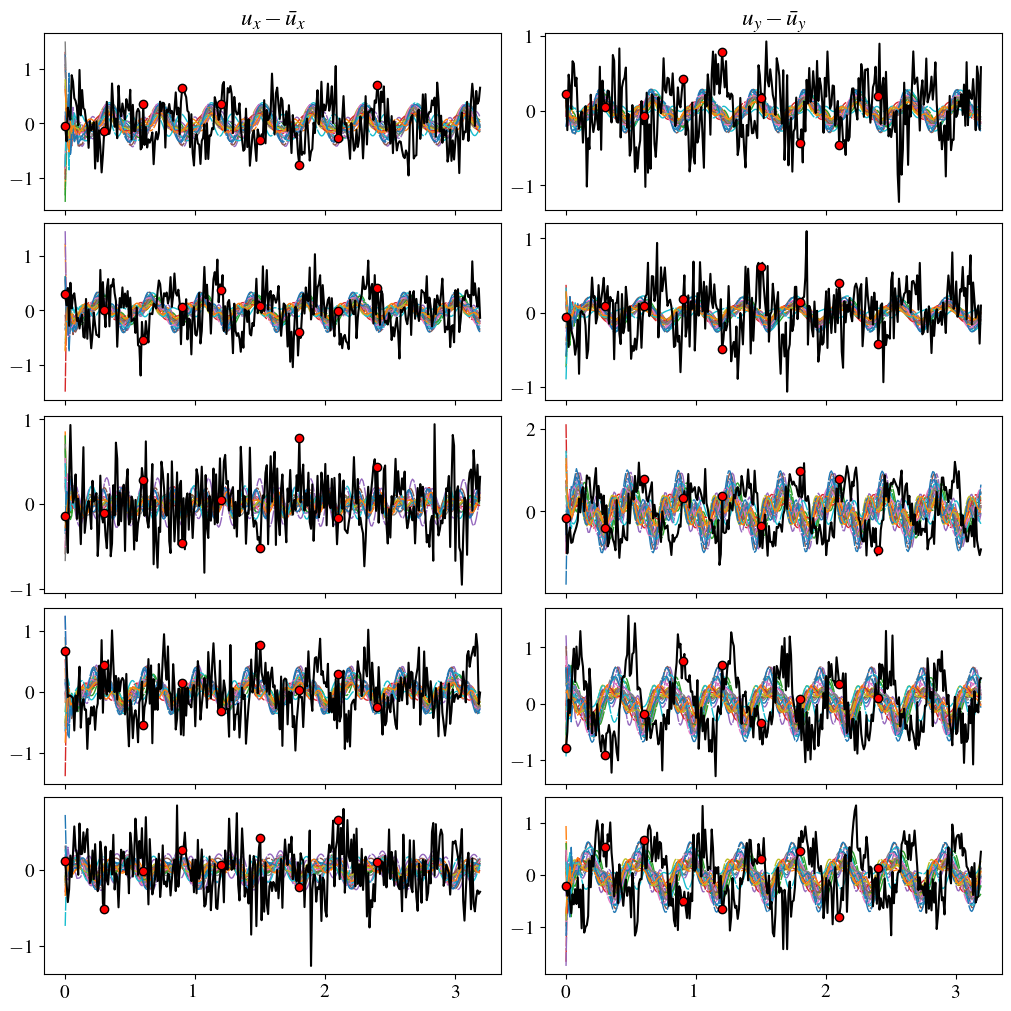

In [6]:
psi, t = ensemble.time_integrate(Nt=N_test)
ensemble.update_history(psi, reset=True)
obs = ensemble.get_observable_hist(N_test)

q_mean = ensemble.Q_mean[ensemble.sensor_locations]

fig, axs = plt.subplots(nrows=ensemble.Nq//2, ncols=2, figsize=(10, 10), sharex=True, layout='constrained')

axs = axs.T.flatten()
axs[0].set(title="$u_x-\\bar{u}_x$")
axs[case.Nq//2].set(title="$u_y-\\bar{u}_y$")

for kk, ax in enumerate(axs):
    ax.plot(ensemble.hist_t[-N_test:], obs[kk] - q_mean[kk], lw=1., ls=(0, (10, 1)))
    ax.plot(truth['t'], data_obs[:,kk] - q_mean[kk], lw=1.5, color='k')
    ax.plot(truth['t_obs'], truth['y_obs'][:,kk] - q_mean[kk], 'o', mec='k', mfc='r')

In [7]:
print(ensemble.get_current_state.shape,
      ensemble.hist.shape,
      ensemble.hist_t.shape,
      ensemble.get_observables().shape,
      ensemble.Q_mean.shape,
      ensemble.Sigma.shape,
      ensemble.Psi.shape
      )



(110, 22) (320, 110, 22) (320,) (10, 22) (132354, 1) (10,) (132354, 10)


In [8]:
int(np.round((truth['t_obs'][0] - ensemble.get_current_time) / ensemble.dt))

-319

In [9]:
ensemble.get_current_time

3.19

In [12]:
from essentials.DA import *

filter_ens = create_ensemble(**forecast_params)


filter_ens.inflation = 1.0
filter_ens.reject_inflation = 1.0
filter_ens.filter = 'EnKF'


filter_ens = dataAssimilation(filter_ens, y_obs=truth['y_obs'].copy(), t_obs=truth['t_obs'].copy(), std_obs=0.1)

#Forecast the ensemble further without assimilation
Nt_extra = int(filter_ens.t_CR / filter_ens.dt) * 10

psi, t = filter_ens.time_integrate(Nt_extra)
filter_ens.update_history(psi, t)


filter_ens.close()
    


 ------------------ POD-ESN Model Parameters ------------------ 

 ---------------- NoBias bias model parameters --------------- 
	 N_ens = 1
	 bayesian_update = False
	 upsample = 1

 -------------------- ASSIMILATION PARAMETERS -------------------- 
 	 Filter = EnKF  
	 bias = NoBias 
 	 m = 22 
 	 Time steps between analysis = None 
 	 Inferred params = [] 
 	 Inflation = 1.0 
 	 Ensemble std(psi0) = 0.5
 	 Ensemble std(alpha0) = 0.001
 	 Number of analysis steps = 9, t0=0.0, t1=2.4
 --------------------------------------------
Elapsed time to first observation: 0.0006189346313476562 s
Assimilation progress: 
	0 % 

ValueError: shape mismatch: value array of shape (10,1) could not be broadcast to indexing result of shape (20,1)

In [18]:

filter_ens = create_ensemble(**forecast_params)

filter_ens.bias.hist.shape
filter_ens.bias.N_dim

20

In [ ]:

y = filter_ens.get_observable_hist(Nt_extra)